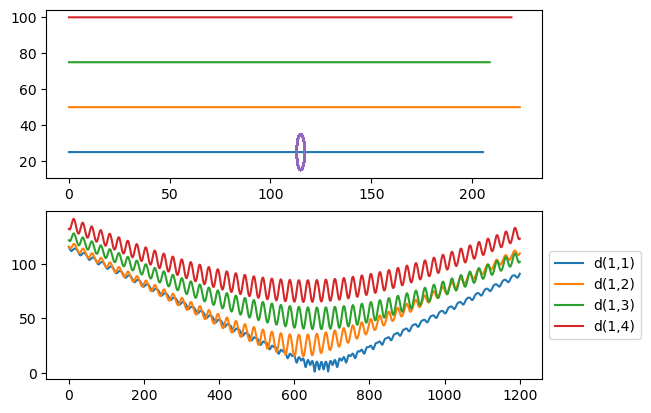

In [1]:
from position import *
from compute import *
from emissions import *
from dataclasses import dataclass
from scipy import stats
from itertools import product
import numpy as np
from functools import partial
from functional import *
import matplotlib.pyplot as plt 

rng_seed = 25

positions = {}
## sensors positions

n_sensors = 4
pos_func = linear
start = np.array((np.zeros(n_sensors), np.arange(1, n_sensors+1)*25)).T
velocity = np.random.normal(1.8,
                    0.1, size = n_sensors)
angle = np.zeros(n_sensors)

snsr_params = {'start': start, 'velocity': velocity, 'angle': angle}
positions['sensors'] = partial(pos_func, **snsr_params)


## source posisitons
n_sources = 1 
pos_func = elliptical
center = np.array([[115,25]])
a = np.array([10])
b = np.array([2])
phi = np.array([np.pi/2])
periods = np.array([50])

src_params = {'center': center, 'a': a, 'b': b, 'phi': phi, 'periods': periods}
positions['sources'] = partial(pos_func, **src_params)

## source emittions
emission_dist = stats.norm
emission_dist_params = lambda x: {'loc': x, 'scale': 0.25*x}
emission_dilution = inv_sql
emission_params =  {'strength': 15, 'scale': 7}

def emisson_effect(distances):
    dil = partial(emission_dilution, **emission_params)
    return compose(dil, emission_dist_params)(distances)

### noise emmisions
background_dist = stats.gengamma
background_dist_params = lambda: dict(a=0.75, c = 2.6, loc=0, scale= 0.4625)
background_dilution = lambda: 0
background_params = lambda: 0


### sim params
length = 120
hz = 10 
trials = 1000
dt = 1/hz
steps = hz*length
sim_params = {'length': length, 'hz': hz, 'trials': trials, 'dt': dt, 'steps': steps}


## get fine positions & distances
P = map(partial(f_kwargs, arg_dict = sim_params), positions.values())
positions = dict(zip(positions.keys(), P))
distances = compute_all_distances(positions['sensors'], positions['sources'])


## plot
fig, ax = plt.subplots(2,1)

for k,v in positions.items():
    ax[0].plot(*v.T)

for i,j in product(*map(range, distances.shape[:-1])):
    ax[1].plot(distances[i,j], label = f'd({i+1},{j+1})')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

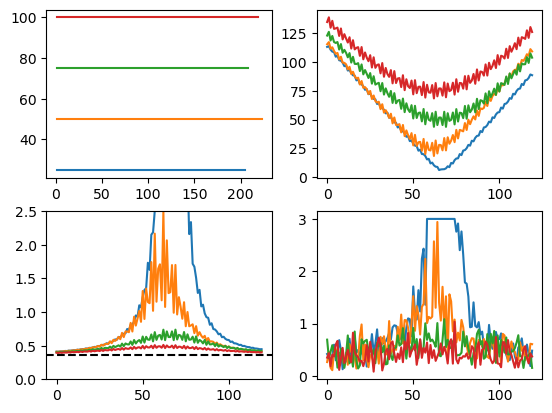

In [30]:
# integration
## latent
_distances = naive_path_integral(lambda x: x, distances)
_effect = emisson_effect(_distances)
_noise = background_dist(**background_dist_params()).mean()
_pairwise_samples = np.moveaxis(emission_dist(**_effect).rvs(size = (trials, n_sources, n_sensors, int(length))), 0,-2)
_background_samples = np.moveaxis(background_dist(**background_dist_params()).rvs(size = (trials, n_sensors,int(length))), 0,-2)

## observed
obs_pos = np.array([naive_path_integral(lambda x:x, positions['sensors'][:,:,i]) for i in range(2)])   
obs_pos = np.moveaxis(obs_pos, 0, -1)
readings = _pairwise_samples.sum(axis = 0) + _background_samples

## plot
fig, ax = plt.subplots(2,2)
for i,v in enumerate(obs_pos):
    ax[0,0].plot(*v.T, label = f'Sensor {i+1}')

for i,j in product(*map(range, distances.shape[:-1])):
    ax[0,1].plot(_distances[i,j], label = f'd({i+1},{j+1})')

for i,j in enumerate(_effect['loc'][0]):
    ax[1,0].plot(j+_noise, label = f'Sensor {i+1}')
    ax[1,0].set_ylim(0,2.5)
ax[1,0].axhline(_noise, color = 'black', linestyle = '--', label = 'Noise Floor')


# fixing trials
def get_trials(arr, idx):
    return arr[...,idx,:]

for i,v in enumerate(get_trials(readings, 0)):
    ax[1,1].plot(np.where(v>3, 3, v))

                 
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.show()

In [ ]:
# get metrics over sensor axis (axis = 0), result is (trials, length)

naive_metric = lambda readings: readings.max(axis = 0)
simple_chi2_metric = lambda readings: stats.chi2(len(readings)).sf((readings**2).sum(axis = 0))

def chi2_metric(readings, alpha):
    c2 = stats.chi2(1).ppf(1-alpha)
    z = (readings**2).sum(axis = 0)*c2
    return stats.chi2(len(readings)).sf(z)

naive_decision = lambda metric: np.where(metric > 1, 1, 0)
chi2_decision = lambda metric, alpha: np.where(metric < alpha, 1, 0)

alpha = 1/3600

naive_method = compose(naive_metric, naive_decision)
chi2_method = compose(partial(chi2_metric, alpha = alpha), partial(chi2_decision, alpha = alpha))

naive_fa = naive_method(_background_samples)
chi2_fa = chi2_method(_background_samples)


## meta algo

readings 

(4, 1000, 120)

In [ ]:
# make viz tool
## visualize backgound dist and emission dist
# define dataclasses
# create modules (utility, simulation, methods, evaluation)
# more complex data generation 


# 5k samples for empirical distribution
# define naive metric
# define chi2 metric
# define meta metric
# define XGB Classifier

# define decision rules
# define MDA(n, alpha) what is the minimum distance that yields true 50% of the time
# define latent FAR
# define TAR
# define ROC












